In [1]:
# Sean Dougherty
# 15/5/2022
# ppc_agn_merger.py analysis notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/pair_prob/'

## PPC at different 2sigma cuts

In [701]:
# # read in results
sig_cut = 10
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
rdf

,prime_index,partner_index,arc_sep,mass_ratio,kpc_sep,pair_prob,prime_z,partner_z,prime_M,partner_M,prime_LX,partner_LX,prime_PDFsig,partner_PDFsig,field,iso_count
0,0,5,14.881563,0.670000,93.643295,0.115461,0.53,0.70,10.430000,9.760000,-8.472344e+58,-1.563071e+59,0.092,0.095,GDS,2007
1,0,34,15.084491,0.300000,94.920233,0.000109,0.53,1.14,10.430000,10.130000,-8.472344e+58,-4.529897e+59,0.092,0.133,GDS,2007
2,0,40,10.765069,0.380000,67.739965,0.000000,0.53,2.09,10.430000,10.050000,-8.472344e+58,-1.618324e+60,0.092,0.331,GDS,2007
3,1,4,10.612850,0.590000,89.608854,0.000000,1.80,2.95,9.980000,9.390000,-1.190616e+60,-3.223095e+60,0.182,0.060,GDS,2007
4,1,14,11.792235,0.480000,99.566915,0.021224,1.80,2.78,9.980000,9.500000,-1.190616e+60,-2.868010e+60,0.182,0.501,GDS,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265403,20640,16726,6.131970,0.320335,50.511073,0.011885,1.15,0.57,9.060698,8.740363,-4.615942e+59,-9.944176e+58,2.842,0.135,UDS,2496
265404,20640,16750,6.564789,0.027274,54.076349,0.058332,1.15,0.82,9.060698,9.033424,-4.615942e+59,-2.212334e+59,2.842,0.112,UDS,2496
265405,20640,17010,6.280011,0.278942,51.730540,0.294722,1.15,1.59,9.060698,8.781755,-4.615942e+59,-9.193822e+59,2.842,0.559,UDS,2496
265406,20640,17212,8.135705,0.408451,67.016509,0.139515,1.15,0.94,9.060698,8.652246,-4.615942e+59,-2.981779e+59,2.842,0.077,UDS,2496


In [512]:
# # add an AGN count per pair column:
# rdf['mAGN'] = [0]*len(rdf)

# LX_AGN = 10**42
# rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
# rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [702]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

AGN_frac = {}
dif_cuts = {}
iso_count = {}
PDF_width = {}
sig_cuts = [10,3,2,1,0.5,0.25]

for sig_cut in sig_cuts:
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)

    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    PDF_width[str(sig_cut)] = np.zeros(len(bins))

    # split data frame up into each bin
    for i, rnge in enumerate(bins):
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])

        # sort into bins
        bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) ]#& (rdf['prime_M'] > 10) ]

        # calculating AGN per pair here
        AGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])) #* len(bin_df))
        PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 

    # get graphical data
    pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    dif_cuts[str(sig_cut)] = pAGN_fracs
    iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

In [703]:
def make_bins_PDF(max_dist=100, n_bins=10):

    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    
    return all_bins

In [704]:
# # well this didn't work bc no data but it should've
# # get graphical data
# pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

In [705]:
# # plot results:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# ax.scatter(kpc_meds, pAGN_fracs)
# ax.set_xlim(0,100)
# plt.show()

In [706]:
# PDF_width

In [707]:
# dif_cuts[str(sig_cut)] = pAGN_fracs
# iso_count[str(sig_cut)] = len(rdf) / sum(rdf['iso_count'].unique())

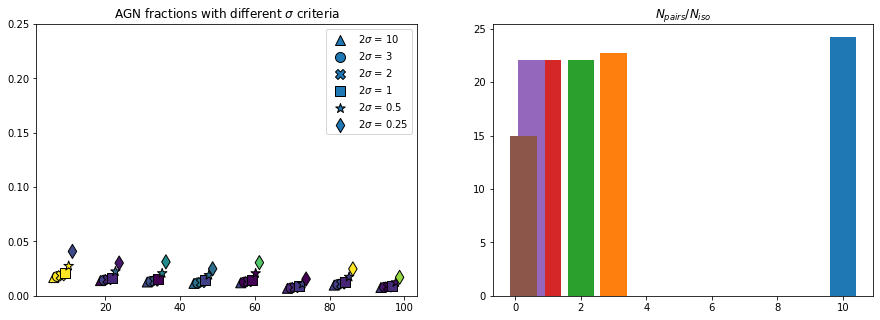

In [708]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
marker = ['^','o','X','s','*','d']
for i, key in enumerate(dif_cuts):
    kpc_medu = [km+i for km in kpc_meds]
    ax[0].scatter(kpc_medu, dif_cuts[key],s=100, c=PDF_width[key], marker=marker[i], edgecolors='black', label='2$\sigma$ = '+key)
    ax[0].set_title('AGN fractions with different $\sigma$ criteria')
    ax[0].set_ylim(0,0.25)
    ax[0].legend()
    # cbar = fig.colorbar(pdat, ax=ax[0], vmax=2, vmin=0)
    # cbar.set_label('mean $2\sigma$', fontsize=15)
    ax[1].bar(float(key), iso_count[key], label='2$\sigma$ = '+key)
    ax[1].set_title('$N_{pairs} / N_{iso}$')
plt.show()

## next plot the difference in AGN fraction at different pair_prob cuts


In [396]:
prob_dat = {}
iso_count = {}
pair_count = {}

In [459]:
# read in results
sig_cut = 0.25
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

In [460]:
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

In [770]:
# calculate AGN fractions:

# create bins:
max_dist=100
n_bins=8
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

# AGN_frac = {}

probc = [0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]

AGN_frac = {}
prob_dat = {}
iso_count = {}
pair_count = {}
npairs = {}

sig_cuts = [10,3,2,1,0.5,0.25]

for sig_cut in sig_cuts:
    print(sig_cut)
    rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
    # add an AGN count per pair column:
    rdf['mAGN'] = [0]*len(rdf)
    LX_AGN = 10**42
    rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
    
    AGN_frac[str(sig_cut)] = np.zeros((len(probc), n_bins))
    npairs[str(sig_cut)] = np.zeros((len(probc),1))

    for i, p in enumerate(probc):
        rdf2 = rdf.loc[ (rdf['pair_prob'] > p) & (rdf['prime_M'] > 10) ]#& (rdf['prime_z'] < 3) ]
        npairs[str(sig_cut)][i] = len(rdf2)

        # split data frame up into each bin
        for j, rnge in enumerate(bins):
            # get bin ranges from bins dictionary entries
            info = bins[rnge].split('-')
            low = float(info[0])
            high = float(info[1])

            # sort into bins
            bin_df = rdf2[ (rdf2['kpc_sep'] > low) & (rdf2['kpc_sep'] <= high) ]

            # calculating AGN per pair here
            AGN_frac[str(sig_cut)][i,j] = (sum(bin_df['pair_prob'] * bin_df['mAGN']) / (sum(bin_df['pair_prob'])))# * len(bin_df)))

    kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

    prob_dat = AGN_frac
    iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
    pair_count = npairs

10
3
2
1
0.5
0.25


In [771]:
bin_df

,prime_index,partner_index,arc_sep,mass_ratio,kpc_sep,pair_prob,prime_z,partner_z,prime_M,partner_M,prime_LX,partner_LX,prime_PDFsig,partner_PDFsig,field,iso_count,mAGN
0,0,3,14.881563,0.670000,93.643295,0.115461,0.53,0.70,10.430000,9.760000,-8.472344e+58,-1.563071e+59,0.092,0.095,GDS,1062,0
1,0,16,15.084491,0.300000,94.920233,0.000109,0.53,1.14,10.430000,10.130000,-8.472344e+58,-4.529897e+59,0.092,0.133,GDS,1062,0
5,8,1,11.626051,0.070000,92.332013,0.000031,2.68,1.80,10.050000,9.980000,-2.667591e+60,-1.190616e+60,0.245,0.182,GDS,1062,0
43,43,32,12.372421,0.280000,87.895378,0.268696,0.69,0.61,10.060000,9.780000,-1.514377e+59,-1.154596e+59,0.230,0.153,GDS,1062,0
131,104,126,11.006459,0.680000,93.233183,0.576075,1.58,1.62,10.770000,10.090000,-9.072964e+59,-9.560971e+59,0.132,0.186,GDS,1062,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93536,11081,10909,10.854390,0.410477,91.778421,0.958815,1.75,1.58,10.089905,9.679428,-1.123047e+60,-9.072964e+59,0.201,0.244,UDS,1593,0
93625,11137,11148,10.636201,0.086528,89.762191,0.111178,1.42,1.76,10.190332,10.103804,-7.244068e+59,-1.136413e+60,0.056,0.217,UDS,1593,0
93782,11204,9869,10.584555,0.174596,89.557269,0.000055,1.72,2.33,10.462398,10.287802,-1.083396e+60,-2.017003e+60,0.099,0.195,UDS,1593,0
93820,11227,10771,11.126692,0.319804,93.978149,0.962310,1.44,1.41,10.017033,9.697229,-7.461798e+59,-7.136379e+59,0.097,0.104,UDS,1593,0


In [772]:
# # get graphical data
# # pAGN_fracs = [AGN_frac[col] for col in AGN_frac]
# kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# prob_dat[str(sig_cut)] = AGN_frac
# iso_count[str(sig_cut)] = sum(rdf['iso_count'].unique())
# pair_count[str(sig_cut)] = npairs

In [773]:
# kpc_meds

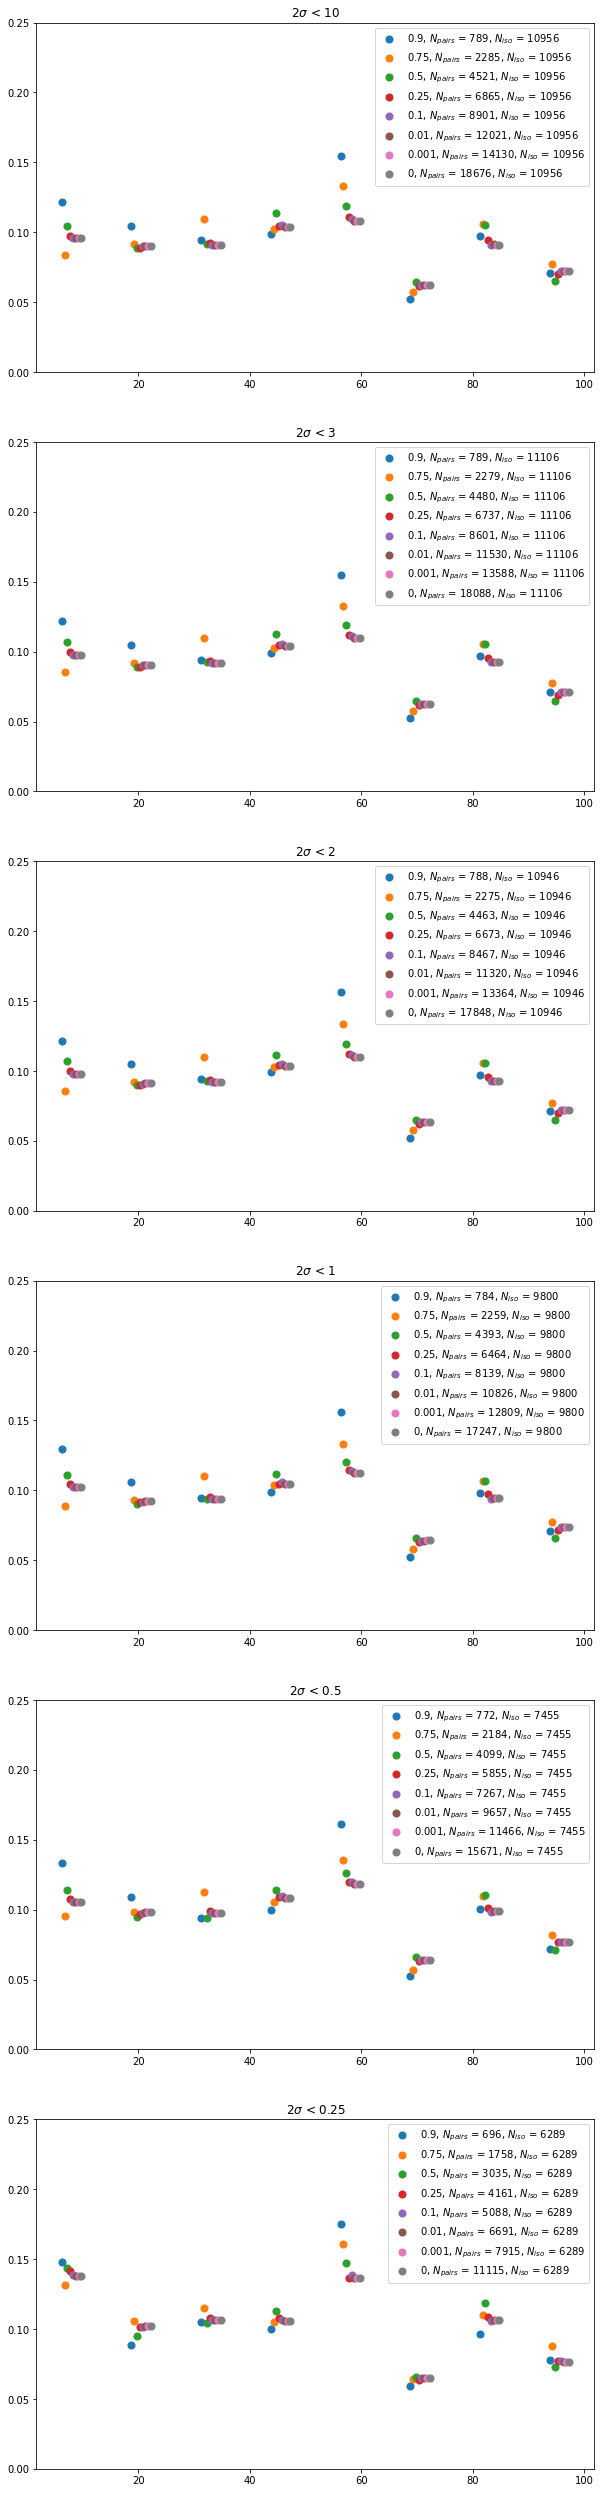

In [774]:
fig, ax = plt.subplots(nrows=6, figsize=(10,45))

for k, key in enumerate(prob_dat):
    for i in range(0,len(prob_dat[key])):
        kpc_medu = [km+(i*0.5) for km in kpc_meds]
        ax[k].scatter(kpc_medu, prob_dat[key][i], label=str(probc[i])+', $N_{pairs}$ = '+str(int(pair_count[key][i]))+
                     ', $N_{iso}$ = '+str(int(iso_count[key])), s=50)
    #ax[k].set_ylim(0,8e-5)
    ax[k].set_ylim(0,0.25)
    ax[k].set_title('2$\sigma$ < '+key)
    ax[k].legend(fontsize=10)
    
plt.show()     

### remember this is AGN fraction per pairs ###

## Compare pair and control sample distributions:

In [815]:
sig_cut = 0.3
rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/pair_prob/pair_data_s0.3.csv'

In [814]:
# create bins:
max_dist=150
n_bins=12
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)

rdf = pd.read_csv(PATH+'pair_data_s'+str(sig_cut)+'.csv')
# add an AGN count per pair column:
rdf['mAGN'] = [0]*len(rdf)
rdf['iAGN'] = [0]*len(rdf)

LX_AGN = 10**42
rdf.loc[ rdf['prime_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1
rdf.loc[ rdf['partner_LX'] > LX_AGN, 'mAGN' ] = rdf['mAGN']+1

rdf.loc[ rdf['c1prime_LX'] > LX_AGN, 'iAGN' ] = rdf['iAGN']+1
rdf.loc[ rdf['c2prime_LX'] > LX_AGN, 'iAGN' ] = rdf['iAGN']+1
rdf.loc[ rdf['c1partner_LX'] > LX_AGN, 'iAGN' ] = rdf['iAGN']+1
rdf.loc[ rdf['c2partner_LX'] > LX_AGN, 'iAGN' ] = rdf['iAGN']+1

rdf = rdf[ rdf['prime_M'] > 10 ]

pAGN_frac = {}
iAGN_frac = {}
# for rnge in bins:
#     pAGN_frac[bins[rnge]] = []
#     iAGN_frac[bins[rnge]] = []
    
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) )
iz = np.concatenate( (rdf.loc[ rdf['c1prime_z']!=-99, 'c1prime_z' ], rdf.loc[ rdf[ 'c2prime_z']!=-99, 'c2prime_z' ], 
                      rdf.loc[ rdf['c1partner_z']!=-99, 'c1partner_z' ], rdf.loc[ rdf['c2partner_z']!=-99, 'c2partner_z'] ) )
imass = np.concatenate( (rdf.loc[ rdf['c1prime_M']!=-99, 'c1prime_M' ], rdf.loc[ rdf[ 'c2prime_M']!=-99, 'c2prime_M' ], 
                      rdf.loc[ rdf['c1partner_M']!=-99, 'c1partner_M' ], rdf.loc[ rdf['c2partner_M']!=-99, 'c2partner_M'] ) )
isig = np.concatenate( (rdf.loc[ rdf['c1prime_sig']!=-99, 'c1prime_sig' ], rdf.loc[ rdf[ 'c2prime_sig']!=-99, 'c2prime_sig' ], 
                      rdf.loc[ rdf['c1partner_sig']!=-99, 'c1partner_sig' ], rdf.loc[ rdf['c2partner_sig']!=-99, 'c2partner_sig'] ) )



# split data frame up into each bin
for i, rnge in enumerate(bins):
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])

    # sort into bins
    bin_df = rdf[ (rdf['kpc_sep'] > low) & (rdf['kpc_sep'] <= high) ]

    # calculating AGN per pair here                                        # this seems to be area of difference...
    pAGN_frac[bins[rnge]] = sum(bin_df['pair_prob'] * 0.5*bin_df['mAGN']) / (sum(bin_df['pair_prob'])) # * len(bin_df))
    iAGN_frac[bins[rnge]] = ( (len(bin_df.loc[bin_df['c1prime_LX'] > LX_AGN]) + len(bin_df.loc[bin_df['c2prime_LX'] > LX_AGN]) +
                             len(bin_df.loc[bin_df['c1partner_LX'] > LX_AGN]) + len(bin_df.loc[bin_df['c2partner_LX'] > LX_AGN])) /
                             (len(bin_df.loc[bin_df['c1prime_LX'] != -99]) + len(bin_df.loc[bin_df['c2prime_LX'] != -99]) +
                              len(bin_df.loc[bin_df['c1partner_LX'] != -99]) + len(bin_df.loc[bin_df['c2partner_LX'] != -99])) )
    
    
    # PDF_width[str(sig_cut)][i] = np.mean( np.concatenate((bin_df['prime_PDFsig'], bin_df['partner_PDFsig'])) ) 



# get graphical data
pAGN_fracs = [pAGN_frac[col] for col in pAGN_frac]
iAGN_fracs = [iAGN_frac[col] for col in iAGN_frac]
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]
AGN_enh = np.array(pAGN_fracs) / np.array(iAGN_fracs)


KeyError: 'c1prime_LX'

In [ ]:
# pAGN_fracs

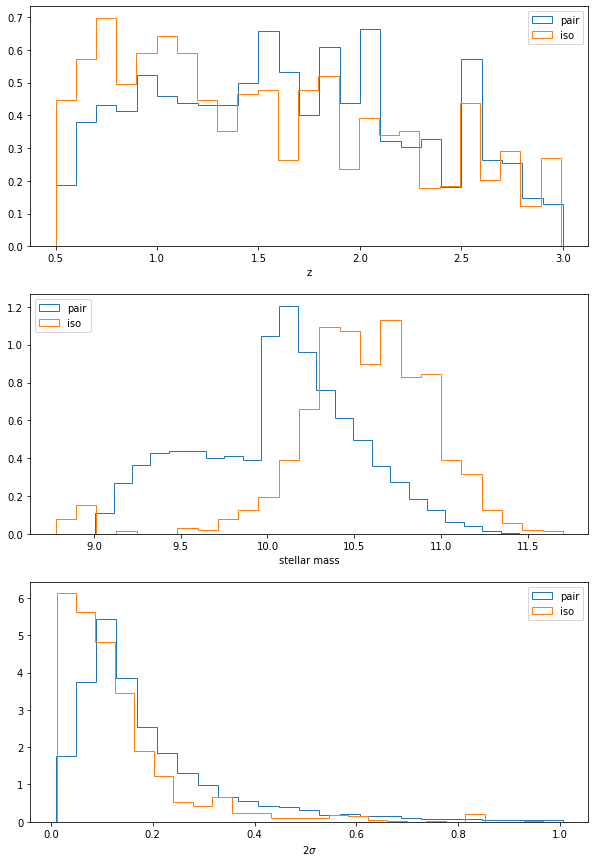

In [812]:
# plot distributions
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,15))
ax[0].hist(pz, bins=25, histtype='step', density=True, label='pair')
ax[0].hist(iz, bins=25, histtype='step', density=True, label='iso')
ax[0].set_xlabel('z')
ax[0].legend()

ax[1].hist(pmass, bins=25, histtype='step', density=True, label='pair')
ax[1].hist(imass, bins=25, histtype='step', density=True, label='iso')
ax[1].set_xlabel('stellar mass')
ax[1].legend()

ax[2].hist(psig, bins=25, histtype='step', density=True, label='pair')
ax[2].hist(isig, bins=25, histtype='step', density=True, label='iso')
ax[2].set_xlabel('2$\sigma$')
ax[2].legend()

plt.show()

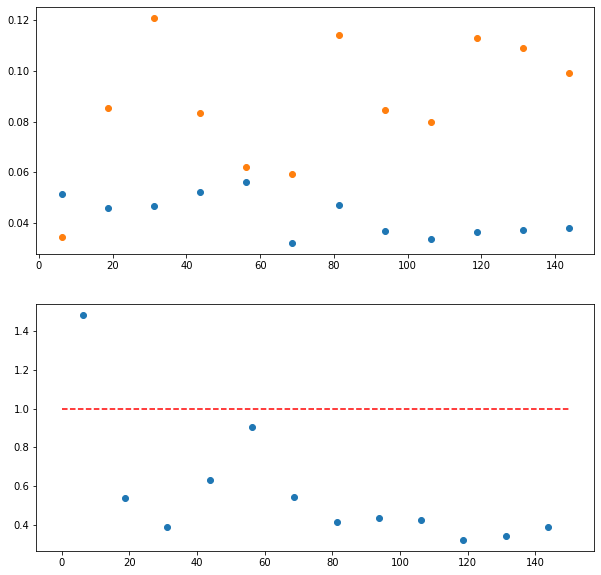

In [809]:
# plot AGN fractions / enhancement:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].scatter(kpc_meds,pAGN_fracs)
ax[0].scatter(kpc_meds,iAGN_fracs)

ax[1].scatter(kpc_meds, AGN_enh)
ax[1].plot([0,150],[1,1], color='r', linestyle='--')

plt.show()